# Frost heave compaction solver

This notebook solves a frost heave compaction problem in one spatial dimension (vertical). 

The code requires [FEniCSx](https://fenicsproject.org). The notebook can be run 
through a [Docker](https://www.docker.com) container with the command:

`docker run --init -ti -p 8888:8888 -v $(pwd):/home/fenics/shared -w /home/fenics/shared dolfinx/lab:stable`

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
from dolfinx.fem import Constant, Function, FunctionSpace, Expression
from dolfinx.mesh import create_interval
from constitutive import sat, temp, perm, Nc
from mpi4py import MPI
from params import nz,zf
from petsc4py import PETSc
from solvers import full_solve,vel_solve, Nr
from ufl import FiniteElement, MixedElement, Dx, SpatialCoordinate
from plotting import plot, plot_movie
from fem_spaces import mixed_space

Define domain:

In [3]:
# generate mesh, initial domain is scaled height of 1 
zl = zf+8
zb = zf-1
domain = create_interval(MPI.COMM_WORLD,nz,[zb,zl])

Define initial porosity $\phi_0$  and effecive pressure $N=N_f$  at base of fringe

In [4]:
phi0 = 0.25 
Nf = 2 # effective stress at base of fringe in rigid solution

Plot saturation, permeability, temperature:

In [5]:
# z =  domain.geometry.x[:,0]

# T = temp(z)
# S = sat(T)
# K = perm(S)

# plt.figure(figsize=(10,6))
# plt.subplot(131)
# plt.plot(S,z)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.xlabel(r'$S$',fontsize=20)
# plt.ylabel(r'$z$',fontsize=20)
# plt.subplot(132)
# plt.plot(T,z)
# plt.xticks(fontsize=16)
# plt.yticks([])
# plt.xlabel(r'$\theta$',fontsize=20)
# plt.subplot(133)
# plt.plot(K,z)
# plt.gca().yaxis.set_label_position("right")
# plt.gca().yaxis.tick_right()
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.xlabel(r'$k$',fontsize=20)
# plt.ylabel(r'$z$',fontsize=20)
# plt.show()
# plt.close()

Define initial porosity:

In [6]:
V = mixed_space(domain)  # set function space options in fem_spaces.py
initial = Function(V)
initial.sub(1).interpolate(lambda x:phi0+0*x[0])

# define same initial condition function for initial velocity solve
V0 = FunctionSpace(domain, ("CG", 1)) 
phi_0 = Function(V0)
phi_0.interpolate(lambda x:phi0+0*x[0])

Rigid solution:

In [7]:
Nr0, V_heave = Nr(domain,phi_0,Nf)

In [8]:
V_heave

0.0035066174898742454

Define total flux at base of fringe as a perturbation from the flux in the 
initial rigid solution.

In [9]:
q_f = V_heave - 0.1

Solve the momentum balance for the initial porosity to obtain the initial velocity:

In [10]:
q_in = q_f - V_heave
w0,Nc0 = vel_solve(domain,phi_0,q_in)
initial.sub(0).interpolate(w0)

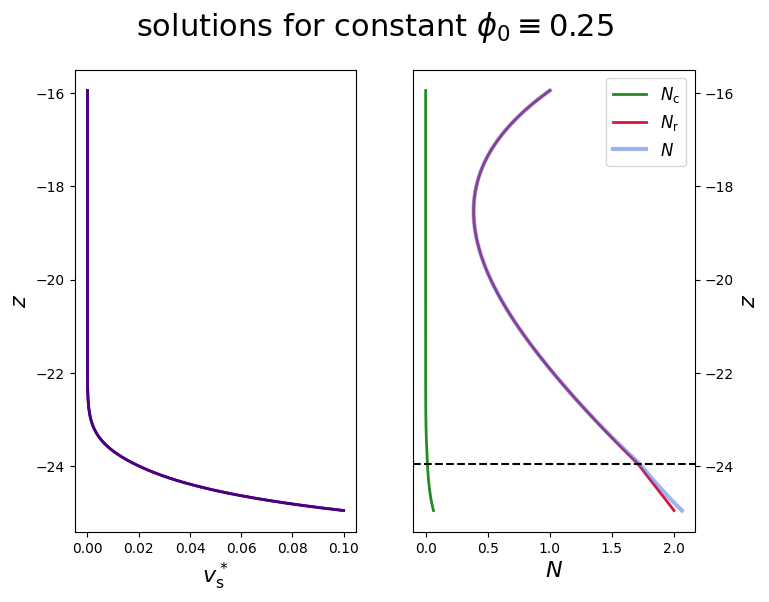

In [11]:
# Plot the solution:


#-------------------------------------------
# plot initial conditions to check ...
z =  SpatialCoordinate(domain)[0]
T = temp(z)
S = sat(T)
Nc0_ = Function(V0)
Nc0_.interpolate(Expression(Nc0, V0.element.interpolation_points()))

z0_ = domain.geometry.x[:,0]
w0_ = w0.x.array
Nc0_ = Nc0_.x.array
Nr0_ = Nr0.x.array

plt.figure(figsize=(8,6))
plt.suptitle(r'solutions for constant $\phi_0\equiv$'+'{:.2f}'.format(phi0),fontsize=22)
plt.subplot(121)
plt.plot(w0_,z0_,color='indigo',linewidth=2,linestyle='-')
# plt.plot(W_i + 0*z0_,z0_,color='indigo',linewidth=2,linestyle='-')
# plt.plot(W_p + 0*z0_,z0_,color='indigo',linewidth=2,linestyle='-')
plt.plot(w0_,z0_,color='indigo',linewidth=2,linestyle='-')
plt.xlabel(r'$v_\mathrm{s}^*$',fontsize=16)
plt.ylabel(r'$z$',fontsize=16)

plt.subplot(122)
plt.plot(Nc0_,z0_,color='forestgreen',linewidth=2,label=r'$N_\mathrm{c}$')
plt.plot(Nr0_,z0_,color='crimson',linewidth=2,label=r'$N_\mathrm{r}$')
plt.plot(Nr0_+Nc0_,z0_,color='royalblue',linestyle='-',linewidth=3,label=r'$N$',alpha=0.5)
plt.axhline(y=zf,color='k',linestyle='--')
plt.xlabel(r'$N$',fontsize=16)
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()
plt.ylabel(r'$z$ ',fontsize=16)
plt.legend(fontsize=12)
plt.show()
plt.close()

In [13]:
timesteps = np.linspace(0,10,1000)

V_pull = 1 # pulling speed (based on initial heave rate)

In [14]:
ws_,phi_, N_, Nr_,Vh_,z_ = full_solve(domain,initial,Nf,V_pull,V_heave,q_f,timesteps)

Plot:

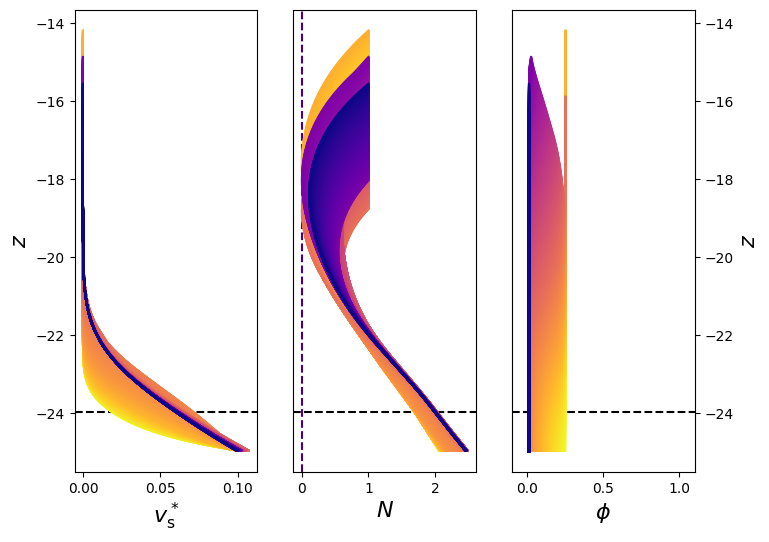

In [15]:
plot(ws_,phi_,N_,Nr_,z_,timesteps)

Plot movie:

In [16]:
# plot a movie, but should probably modify the timestep indices ('ind') 
# in the plotting function so it doesn't plot so many and possibly
# run out of memory in docker 
# plot_movie(ws_,phi_,N_,Nr_,z_,timesteps)

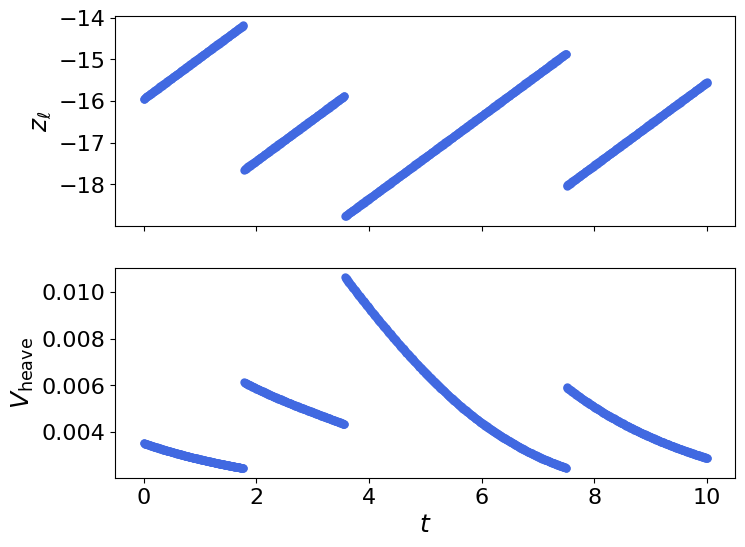

In [16]:
zl = np.max(z_,axis=-1) # lens position
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(timesteps,zl,'o',color='royalblue',markersize=5)
plt.ylabel(r'$z_\ell$',fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.gca().xaxis.set_ticklabels([])
plt.subplot(212)
plt.plot(timesteps,Vh_,'o',color='royalblue',markersize=5)
plt.xlabel(r'$t$',fontsize=18)
plt.ylabel(r'$V_\mathrm{heave}$',fontsize=18)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.show()
plt.close()